#### Lesson: Shortest Paths

In [8]:
import numpy as np

In [9]:
from numpy import inf

Q = np.array([[inf, 1,   5,   3,   inf, inf, inf],
              [inf, inf, inf, 9,   6,   inf, inf],
              [inf, inf, inf, inf, inf, 2,   inf],
              [inf, inf, inf, inf, inf, 4,   8],
              [inf, inf, inf, inf, inf, inf, 4],
              [inf, inf, inf, inf, inf, inf, 1],
              [inf, inf, inf, inf, inf, inf, 0]])

In [10]:
num_nodes = 7
J = np.zeros(num_nodes, dtype=np.int)       # Initial guess
next_J = np.empty(num_nodes, dtype=np.int)  # Stores updated guess
max_iter = 500
i = 0

while i < max_iter:
   for v in range(num_nodes):
      next_J[v] = np.min(Q[v, :] + J)
   if np.equal(next_J, J).all():
      break
   else:
      J[:] = next_J   # Copy contents of next_J to J
      i += 1

print("The cost-to-go function is", J)

The cost-to-go function is [ 8 10  3  5  4  1  0]


Ecercise 1

![Ex1](img/sp_1.png)

In [11]:
num_nodes = 100
destination_node = 99

def map_graph_to_distance_matrix(in_file):

   # First let's set of the distance matrix Q with inf everywhere
   Q = np.ones((num_nodes, num_nodes))
   Q = Q * np.inf

   # Now we read in the data and modify Q
   infile = open(in_file)
   for line in infile:
      elements = line.split(',')
      node = elements.pop(0)
      node = int(node[4:])    # convert node description to integer
      if node != destination_node:
          for element in elements:
              destination, cost = element.split()
              destination = int(destination[4:])
              Q[node, destination] = float(cost)
   Q[destination_node, destination_node] = 0

   infile.close()
   return Q

In [12]:
def bellman(J, Q):
   num_nodes = Q.shape[0]
   next_J = np.empty_like(J)
   for v in range(num_nodes):
      next_J[v] = np.min(Q[v, :] + J)
   return next_J


def compute_cost_to_go(Q):
   J = np.zeros(num_nodes)      # Initial guess
   next_J = np.empty(num_nodes)  # Stores updated guess
   max_iter = 500
   i = 0

   while i < max_iter:
      next_J = bellman(J, Q)
      if np.allclose(next_J, J):
         break
      else:
         J[:] = next_J   # Copy contents of next_J to J
         i += 1

   return(J)

In [13]:
def print_best_path(J, Q):
    sum_costs = 0
    current_node = 0
    while current_node != destination_node:
        print(current_node)
        # Move to the next node and increment costs
        next_node = np.argmin(Q[current_node, :] + J)
        sum_costs += Q[current_node, next_node]
        current_node = next_node

    print(destination_node)
    print('Cost: ', sum_costs)

In [14]:
Q = map_graph_to_distance_matrix('graph.txt')
J = compute_cost_to_go(Q)
print_best_path(J, Q)

0
8
11
18
23
33
41
53
56
57
60
67
70
73
76
85
87
88
93
94
96
97
98
99
Cost:  160.55000000000007


#### Lesson: Job Search I: The McCall Search Model

In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from quantecon.distributions import BetaBinomial

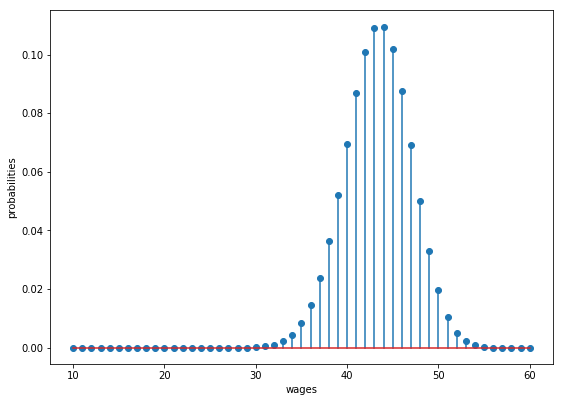

In [2]:
n, a, b = 50, 200, 100
w_min, w_max = 10, 60
w_vals = np.linspace(w_min, w_max, n+1)
dist = BetaBinomial(n, a, b)
ϕ_vals = dist.pdf()

fig, ax = plt.subplots(figsize=(9, 6.5))
ax.stem(w_vals, ϕ_vals, label='$\phi (w\')$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

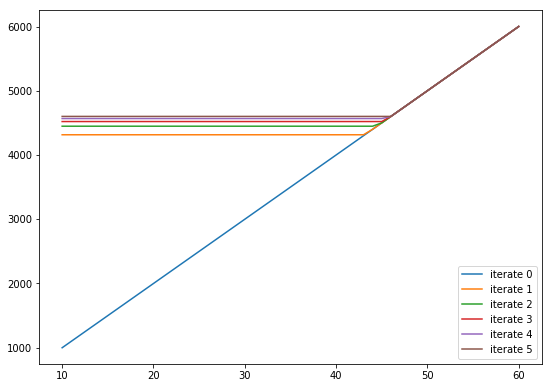

In [3]:
def plot_value_function_seq(ax,
                            c=25,
                            β=0.99,
                            w_vals=w_vals,
                            ϕ_vals=ϕ_vals,
                            num_plots=6):

    v = w_vals / (1 - β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(w_vals, v, label=f"iterate {i}")
        # Update guess
        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * ϕ_vals)
            v_next[j] = max(stop_val, cont_val)
        v[:] = v_next

    ax.legend(loc='lower right')


fig, ax = plt.subplots(figsize=(9, 6.5))
plot_value_function_seq(ax)
plt.show()

In [4]:
@jit(nopython=True)
def compute_reservation_wage(c=25,
                             β=0.99,
                             w_vals=w_vals,
                             ϕ_vals=ϕ_vals,
                             max_iter=500,
                             tol=1e-6):

    # == First compute the value function == #

    v = w_vals / (1 - β)
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * ϕ_vals)
            v_next[j] = max(stop_val, cont_val)

        error = np.max(np.abs(v_next - v))
        i += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * ϕ_vals))

In [5]:
compute_reservation_wage()

47.316499710024964

In [6]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        R[i, j] = compute_reservation_wage(c=c, β=β)

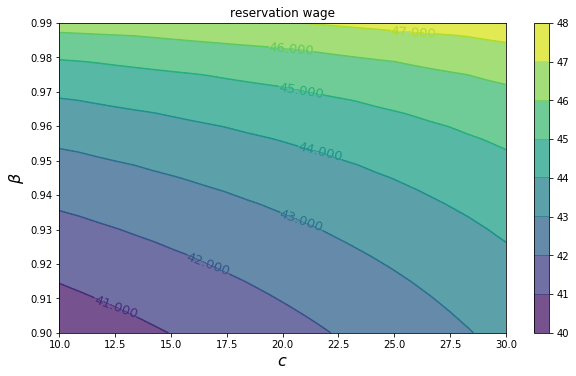

In [7]:
fig, ax = plt.subplots(figsize=(10, 5.7))

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

In [8]:
@jit(nopython=True)
def compute_reservation_wage_two(c=25,
                                 β=0.99,
                                 w_vals=w_vals,
                                 ϕ_vals=ϕ_vals,
                                 max_iter=500,
                                 tol=1e-5):

    # == First compute ϕ == #

    h = np.sum(w_vals * ϕ_vals) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        s = np.maximum(w_vals / (1 - β), h)
        h_next = c + β * np.sum(s * ϕ_vals)

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h

Ecercise 1

![Ex1](img/mccall_1.png)

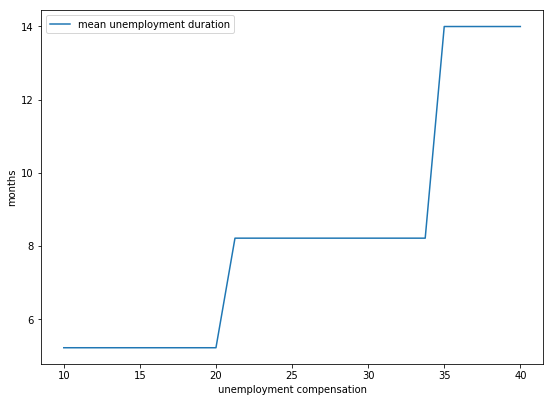

In [9]:
cdf = np.cumsum(ϕ_vals)

@jit(nopython=True)
def compute_stopping_time(w_bar, seed=1234):

    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_vals[qe.random.draw(cdf)]
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

@jit(nopython=True)
def compute_mean_stopping_time(w_bar, num_reps=100000):
    obs = np.empty(num_reps)
    for i in range(num_reps):
        obs[i] = compute_stopping_time(w_bar, seed=i)
    return obs.mean()

c_vals = np.linspace(10, 40, 25)
stop_times = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    w_bar = compute_reservation_wage_two(c=c)
    stop_times[i] = compute_mean_stopping_time(w_bar)

fig, ax = plt.subplots(figsize=(9, 6.5))

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()



#### Lesson: Job Search II: Search and Separation

In [2]:
import numpy as np
from quantecon.distributions import BetaBinomial
from numba import njit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# A default utility function

@njit
def u(c, σ):
    if c > 0:
        return (c**(1 - σ) - 1) / (1 - σ)
    else:
        return -10e6

class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self,
                 α=0.2,        # Job separation rate
                 β=0.98,       # Discount factor
                 γ=0.7,        # Job offer rate
                 c=6.0,        # Unemployment compensation
                 σ=2.0,        # Utility parameter
                 w_vals=None,  # Possible wage values
                 ϕ_vals=None): # Probabilities over w_vals

        self.α, self.β, self.γ, self.c = α, β, γ, c
        self.σ = σ

        # Add a default wage vector and probabilities over the vector using
        # the beta-binomial distribution
        if w_vals is None:
            n = 60  # number of possible outcomes for wage
            self.w_vals = np.linspace(10, 20, n)  # Wages between 10 and 20
            a, b = 600, 400  # shape parameters
            dist = BetaBinomial(n-1, a, b)
            self.ϕ_vals = dist.pdf()
        else:
            self.w_vals = w_vals
            self.ϕ_vals = ϕ_vals

In [4]:
@njit
def Q(v, h, paras):
    """
    A jitted function to update the Bellman equations

    """

    α, β, γ, c, σ, w_vals, ϕ_vals = paras

    v_new = np.empty_like(v)

    for i in range(len(w_vals)):
        w = w_vals[i]
        v_new[i] = u(w, σ) + β * ((1 - α) * v[i] + α * h)

    h_new = u(c, σ) + β * (1 - γ) * h + \
                    β * γ * np.sum(np.maximum(h, v) * ϕ_vals)

    return v_new, h_new

In [5]:
def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    mcm is an instance of McCallModel
    """

    v = np.ones_like(mcm.w_vals)   # Initial guess of v
    h = 1                          # Initial guess of h
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_new, h_new = Q(v, h, (mcm.α, mcm.β, mcm.γ, mcm.c, mcm.σ, \
                                mcm.w_vals, mcm.ϕ_vals)
                        )
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(h_new - h)
        error = max(error_1, error_2)
        v = v_new
        h = h_new
        i += 1

    return v, h

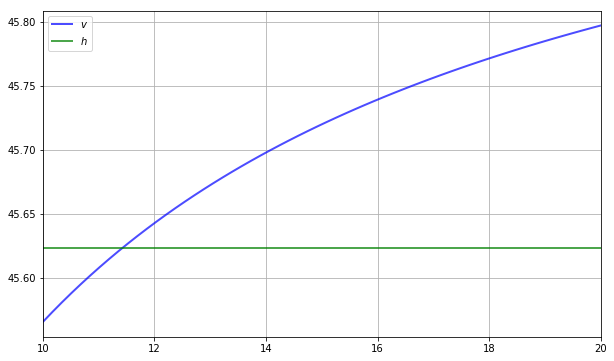

In [6]:
mcm = McCallModel()
v, h = solve_model(mcm)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(mcm.w_vals, v, 'b-', lw=2, alpha=0.7, label='$v$')
ax.plot(mcm.w_vals, [h] * len(mcm.w_vals),
        'g-', lw=2, alpha=0.7, label='$h$')
ax.set_xlim(min(mcm.w_vals), max(mcm.w_vals))
ax.legend()
ax.grid()

plt.show()

In [7]:
def compute_reservation_wage(mcm, return_values=False):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v(w) > h.

    If v(w) > h for all w, then the reservation wage w_bar is set to
    the lowest wage in mcm.w_vals.

    If v(w) < h for all w, then w_bar is set to np.inf.
    """

    v, h = solve_model(mcm)
    w_idx = np.searchsorted(v - h, 0)

    if w_idx == len(v):
        w_bar = np.inf
    else:
        w_bar = mcm.w_vals[w_idx]

    if not return_values:
        return w_bar
    else:
        return w_bar, v, h

Ecercise 1

![Ex1](img/js2_1.png)

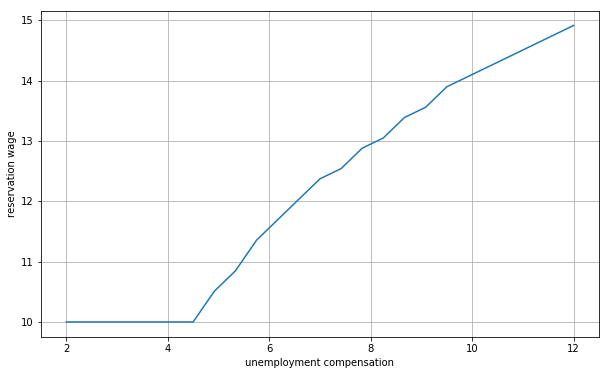

In [8]:
grid_size = 25
c_vals = np.linspace(2, 12, grid_size)  # Unemployment compensation
w_bar_vals = np.empty_like(c_vals)

mcm = McCallModel()

fig, ax = plt.subplots(figsize=(10, 6))

for i, c in enumerate(c_vals):
    mcm.c = c
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='unemployment compensation',
       ylabel='reservation wage')
ax.plot(c_vals, w_bar_vals, label=r'$\bar w$ as a function of $c$')
ax.grid()

plt.show()

Ecercise 2

![Ex2](img/js2_2.png)

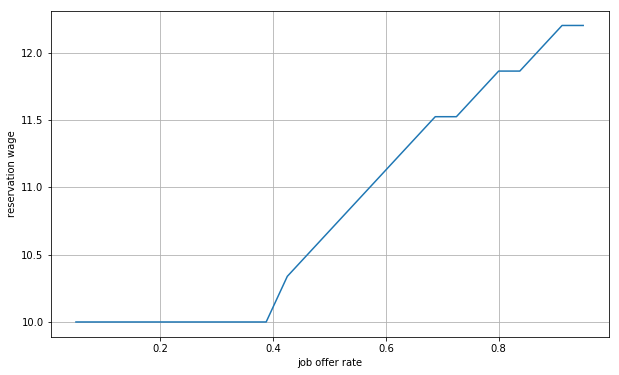

In [9]:
grid_size = 25
γ_vals = np.linspace(0.05, 0.95, grid_size)
w_bar_vals = np.empty_like(γ_vals)

mcm = McCallModel()

fig, ax = plt.subplots(figsize=(10, 6))

for i, γ in enumerate(γ_vals):
    mcm.γ = γ
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.plot(γ_vals, w_bar_vals, label=r'$\bar w$ as a function of $\gamma$')
ax.set(xlabel='job offer rate', ylabel='reservation wage')
ax.grid()

plt.show()

As seen from the graph, the increase in γ affects wage in a positive way.

That's because more jib offer rate results into better job search cobnitions.

#### Lesson: A Problem that Stumped Milton Friedman

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange, vectorize
from interpolation import interp
from math import gamma

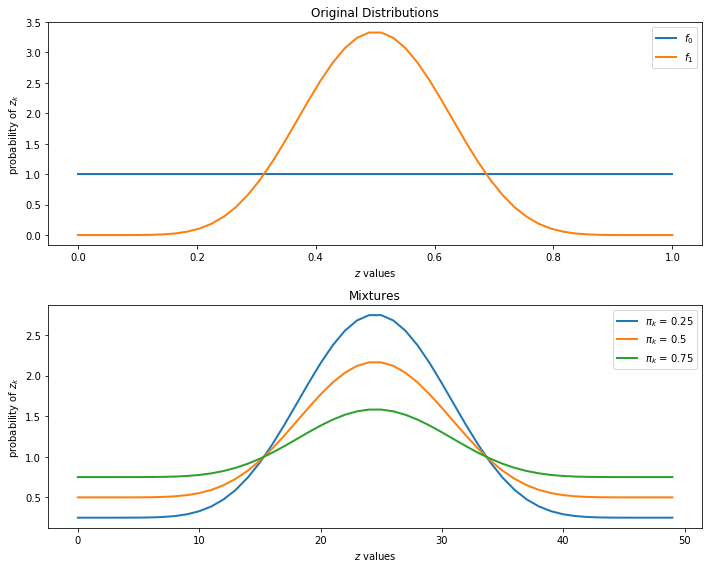

In [11]:
def beta_function_factory(a, b):

    @vectorize
    def p(x):
        r = gamma(a + b) / (gamma(a) * gamma(b))
        return r * x**(a-1) * (1 - x)**(b-1)

    @njit
    def p_rvs():
        return np.random.beta(a, b)

    return p, p_rvs


f0, _ = beta_function_factory(1, 1)
f1, _ = beta_function_factory(9, 9)
grid = np.linspace(0, 1, 50)

fig, axes = plt.subplots(2, figsize=(10, 8))

axes[0].set_title("Original Distributions")
axes[0].plot(grid, f0(grid), lw=2, label="$f_0$")
axes[0].plot(grid, f1(grid), lw=2, label="$f_1$")

axes[1].set_title("Mixtures")
for π in 0.25, 0.5, 0.75:
    y = π * f0(grid) + (1 - π) * f1(grid)
    axes[1].plot(y, lw=2, label=f"$\pi_k$ = {π}")

for ax in axes:
    ax.legend()
    ax.set(xlabel="$z$ values", ylabel="probability of $z_k$")

plt.tight_layout()
plt.show()



In [12]:
class WaldFriedman:

    def __init__(self,
                 c=1.25,         # Cost of another draw
                 a0=1,
                 b0=1,
                 a1=3,
                 b1=1.2,
                 L0=25,          # Cost of selecting f0 when f1 is true
                 L1=25,          # Cost of selecting f1 when f0 is true
                 π_grid_size=200,
                 mc_size=1000):

        self.c, self.π_grid_size = c, π_grid_size
        self.L0, self.L1 = L0, L1
        self.π_grid = np.linspace(0, 1, π_grid_size)
        self.mc_size = mc_size

        # Set up distributions
        self.f0, self.f0_rvs = beta_function_factory(a0, b0)
        self.f1, self.f1_rvs = beta_function_factory(a1, b1)

        self.z0 = np.random.beta(a0, b0, mc_size)
        self.z1 = np.random.beta(a1, b1, mc_size)

In [13]:
def operator_factory(wf, parallel_flag=True):

    """
    Returns a jitted version of the Q operator.

    * wf is an instance of the WaldFriedman class
    """

    c, π_grid = wf.c, wf.π_grid
    L0, L1 = wf.L0, wf.L1
    f0, f1 = wf.f0, wf.f1
    z0, z1 = wf.z0, wf.z1
    mc_size = wf.mc_size

    @njit
    def κ(z, π):
        """
        Updates π using Bayes' rule and the current observation z
        """
        π_f0, π_f1 = π * f0(z), (1 - π) * f1(z)
        π_new = π_f0 / (π_f0 + π_f1)

        return π_new

    @njit(parallel=parallel_flag)
    def Q(h):
        h_new = np.empty_like(π_grid)
        h_func = lambda p: interp(π_grid, h, p)

        for i in prange(len(π_grid)):
            π = π_grid[i]

            # Find the expected value of J by integrating over z
            integral_f0, integral_f1 = 0, 0
            for m in range(mc_size):
                π_0 = κ(z0[m], π)  # Draw z from f0 and update π
                integral_f0 += min((1 - π_0) * L0, π_0 * L1, h_func(π_0))

                π_1 = κ(z1[m], π)  # Draw z from f1 and update π
                integral_f1 += min((1 - π_1) * L0, π_1 * L1, h_func(π_1))

            integral = (π * integral_f0 + (1 - π) * integral_f1) / mc_size

            h_new[i] = c + integral

        return h_new

    return Q

In [14]:
def solve_model(wf,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    """
    Compute the continuation value function

    * wf is an instance of WaldFriedman
    """

    Q = operator_factory(wf, parallel_flag=use_parallel)

    # Set up loop
    h = np.zeros(len(wf.π_grid))
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        h_new = Q(h)
        error = np.max(np.abs(h - h_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        h = h_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return h_new

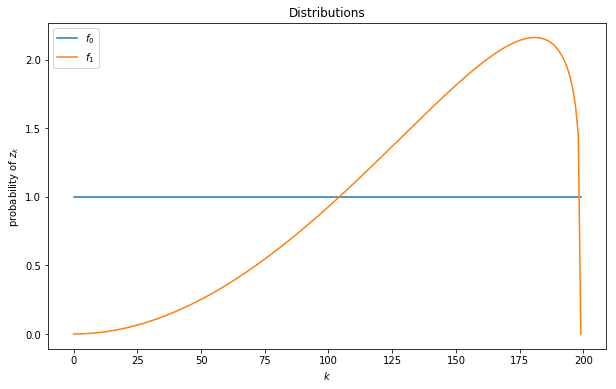

In [15]:
wf = WaldFriedman()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(wf.f0(wf.π_grid), label="$f_0$")
ax.plot(wf.f1(wf.π_grid), label="$f_1$")
ax.set(ylabel="probability of $z_k$", xlabel="$k$", title="Distributions")
ax.legend()

plt.show()

In [16]:
h_star = solve_model(wf)    # Solve the model

Error at iteration 25 is 8.81007470798778e-05.

Converged in 25 iterations.


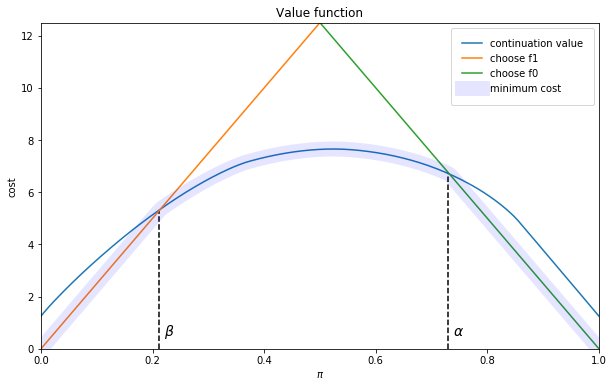

In [17]:
def find_cutoff_rule(wf, h):

    """
    This function takes a continuation value function and returns the
    corresponding cutoffs of where you transition between continuing and
    choosing a specific model
    """

    π_grid = wf.π_grid
    L0, L1 = wf.L0, wf.L1

    # Evaluate cost at all points on grid for choosing a model
    payoff_f0 = (1 - π_grid) * L0
    payoff_f1 = π_grid * L1

    # The cutoff points can be found by differencing these costs with
    # The Bellman equation (J is always less than or equal to p_c_i)
    β = π_grid[np.searchsorted(
                              payoff_f1 - np.minimum(h, payoff_f0),
                              1e-10)
               - 1]
    α = π_grid[np.searchsorted(
                              np.minimum(h, payoff_f1) - payoff_f0,
                              1e-10)
               - 1]

    return (β, α)

β, α = find_cutoff_rule(wf, h_star)
cost_L0 = (1 - wf.π_grid) * wf.L0
cost_L1 = wf.π_grid * wf.L1

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wf.π_grid, h_star, label='continuation value')
ax.plot(wf.π_grid, cost_L1, label='choose f1')
ax.plot(wf.π_grid, cost_L0, label='choose f0')
ax.plot(wf.π_grid,
        np.amin(np.column_stack([h_star, cost_L0, cost_L1]),axis=1),
        lw=15, alpha=0.1, color='b', label='minimum cost')

ax.annotate(r"$\beta$", xy=(β + 0.01, 0.5), fontsize=14)
ax.annotate(r"$\alpha$", xy=(α + 0.01, 0.5), fontsize=14)

plt.vlines(β, 0, β * wf.L0, linestyle="--")
plt.vlines(α, 0, (1 - α) * wf.L1, linestyle="--")

ax.set(xlim=(0, 1), ylim=(0, 0.5 * max(wf.L0, wf.L1)), ylabel="cost",
       xlabel="$\pi$", title="Value function")

plt.legend(borderpad=1.1)
plt.show()

Error at iteration 25 is 8.81007470798778e-05.

Converged in 25 iterations.


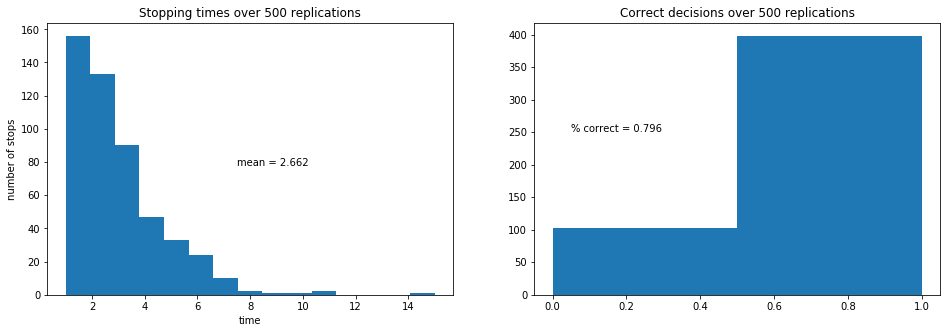

In [18]:
def simulate(wf, true_dist, h_star, π_0=0.5):

    """
    This function takes an initial condition and simulates until it
    stops (when a decision is made)
    """

    f0, f1 = wf.f0, wf.f1
    f0_rvs, f1_rvs = wf.f0_rvs, wf.f1_rvs
    π_grid = wf.π_grid

    def κ(z, π):
        """
        Updates π using Bayes' rule and the current observation z
        """
        π_f0, π_f1 = π * f0(z), (1 - π) * f1(z)
        π_new = π_f0 / (π_f0 + π_f1)

        return π_new

    if true_dist == "f0":
        f, f_rvs = wf.f0, wf.f0_rvs
    elif true_dist == "f1":
        f, f_rvs = wf.f1, wf.f1_rvs

    # Find cutoffs
    β, α = find_cutoff_rule(wf, h_star)

    # Initialize a couple of useful variables
    decision_made = False
    π = π_0
    t = 0

    while decision_made is False:
        # Maybe should specify which distribution is correct one so that
        # the draws come from the "right" distribution
        z = f_rvs()
        t = t + 1
        π = κ(z, π)
        if π < β:
            decision_made = True
            decision = 1
        elif π > α:
            decision_made = True
            decision = 0

    if true_dist == "f0":
        if decision == 0:
            correct = True
        else:
            correct = False

    elif true_dist == "f1":
        if decision == 1:
            correct = True
        else:
            correct = False

    return correct, π, t

def stopping_dist(wf, h_star, ndraws=250, true_dist="f0"):

    """
    Simulates repeatedly to get distributions of time needed to make a
    decision and how often they are correct
    """

    tdist = np.empty(ndraws, int)
    cdist = np.empty(ndraws, bool)

    for i in range(ndraws):
        correct, π, t = simulate(wf, true_dist, h_star)
        tdist[i] = t
        cdist[i] = correct

    return cdist, tdist

def simulation_plot(wf):
    h_star = solve_model(wf)
    ndraws = 500
    cdist, tdist = stopping_dist(wf, h_star, ndraws)

    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    ax[0].hist(tdist, bins=np.max(tdist))
    ax[0].set_title(f"Stopping times over {ndraws} replications")
    ax[0].set(xlabel="time", ylabel="number of stops")
    ax[0].annotate(f"mean = {np.mean(tdist)}", xy=(max(tdist) / 2,
                   max(np.histogram(tdist, bins=max(tdist))[0]) / 2))

    ax[1].hist(cdist.astype(int), bins=2)
    ax[1].set_title(f"Correct decisions over {ndraws} replications")
    ax[1].annotate(f"% correct = {np.mean(cdist)}",
                   xy=(0.05, ndraws / 2))

    plt.show()

simulation_plot(wf)


Converged in 13 iterations.


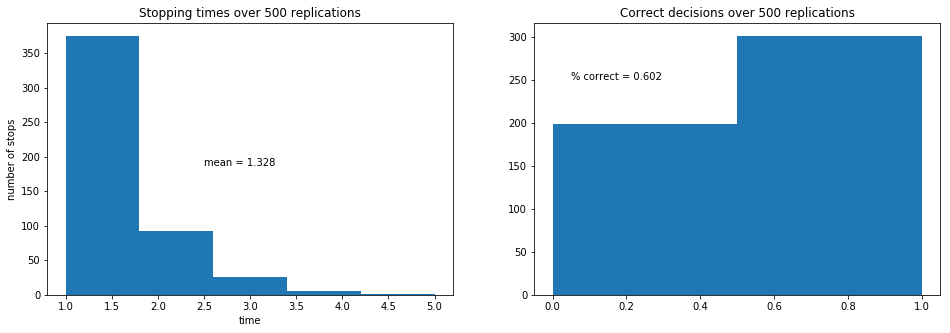

In [19]:
wf = WaldFriedman(c=2.5)
simulation_plot(wf)

#### Lesson: Job Search III: Search with Learning

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from numba import njit, prange, vectorize
from interpolation import mlinterp, interp
from math import gamma

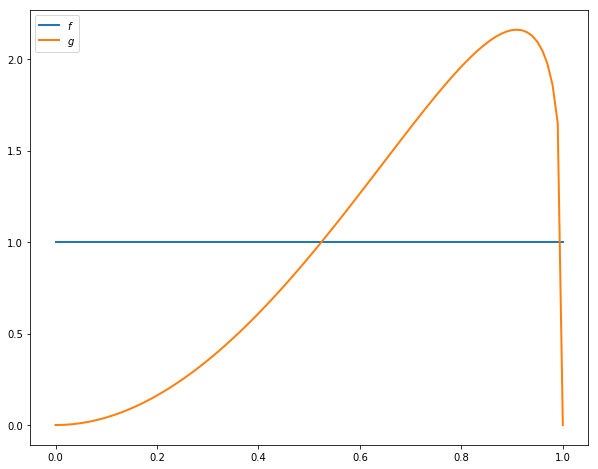

In [21]:
def beta_function_factory(a, b):

    @vectorize
    def p(x):
        r = gamma(a + b) / (gamma(a) * gamma(b))
        return r * x**(a-1) * (1 - x)**(b-1)

    return p


x_grid = np.linspace(0, 1, 100)
f = beta_function_factory(1, 1)
g = beta_function_factory(3, 1.2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_grid, f(x_grid), label='$f$', lw=2)
ax.plot(x_grid, g(x_grid), label='$g$', lw=2)

ax.legend()
plt.show()

In [22]:
class SearchProblem:
    """
    A class to store a given parameterization of the "offer distribution
    unknown" model.

    """

    def __init__(self,
                 β=0.95,            # Discount factor
                 c=0.3,             # Unemployment compensation
                 F_a=1,
                 F_b=1,
                 G_a=3,
                 G_b=1.2,
                 w_max=1,           # Maximum wage possible
                 w_grid_size=100,
                 π_grid_size=100,
                 mc_size=500):

        self.β, self.c, self.w_max = β, c, w_max

        self.f = beta_function_factory(F_a, F_b)
        self.g = beta_function_factory(G_a, G_b)

        self.π_min, self.π_max = 1e-3, 1-1e-3    # Avoids instability
        self.w_grid = np.linspace(0, w_max, w_grid_size)
        self.π_grid = np.linspace(self.π_min, self.π_max, π_grid_size)

        self.mc_size = mc_size

        self.w_f = np.random.beta(F_a, F_b, mc_size)
        self.w_g = np.random.beta(G_a, G_b, mc_size)

In [23]:
def operator_factory(sp, parallel_flag=True):

    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid

    @njit
    def κ(w, π):
        """
        Updates π using Bayes' rule and the current wage observation w.
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)

        return π_new

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator.

        """
        v_func = lambda x, y: mlinterp((w_grid, π_grid), v, (x, y))
        v_new = np.empty_like(v)

        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]

                v_1 = w / (1 - β)

                integral_f, integral_g = 0.0, 0.0
                for m in prange(mc_size):
                    integral_f += v_func(w_f[m], κ(w_f[m], π))
                    integral_g += v_func(w_g[m], κ(w_g[m], π))
                integral = (π * integral_f + (1 - π) * integral_g) / mc_size

                v_2 = c + β * integral
                v_new[i, j] = max(v_1, v_2)

        return v_new

    @njit(parallel=parallel_flag)
    def get_greedy(v):
        """"
        Compute optimal actions taking v as the value function.

        """

        v_func = lambda x, y: mlinterp((w_grid, π_grid), v, (x, y))
        σ = np.empty_like(v)

        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]

                v_1 = w / (1 - β)

                integral_f, integral_g = 0.0, 0.0
                for m in prange(mc_size):
                    integral_f += v_func(w_f[m], κ(w_f[m], π))
                    integral_g += v_func(w_g[m], κ(w_g[m], π))
                integral = (π * integral_f + (1 - π) * integral_g) / mc_size

                v_2 = c + β * integral

                σ[i, j] = v_1 > v_2  # Evaluates to 1 or 0

        return σ

    return T, get_greedy

In [24]:
def solve_model(sp,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=5):

    """
    Solves for the value function

    * sp is an instance of SearchProblem
    """

    T, _ = operator_factory(sp, use_parallel)

    # Set up loop
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid)

    # Initialize v
    v = np.zeros((m, n)) + sp.c / (1 - sp.β)

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")


    return v_new

Error at iteration 5 is 0.6427571312977634.
Error at iteration 10 is 0.10030973018611.
Error at iteration 15 is 0.02183212073153129.
Error at iteration 20 is 0.005001537918992938.
Error at iteration 25 is 0.0011463006506993167.
Error at iteration 30 is 0.00026272322397247194.

Converged in 34 iterations.


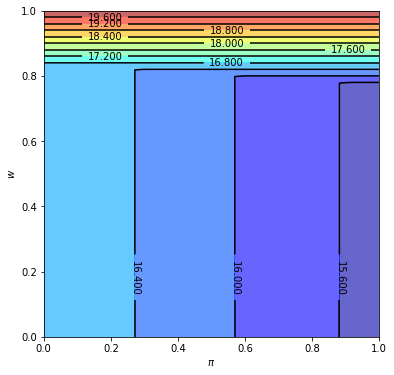

In [25]:
sp = SearchProblem()
v_star = solve_model(sp)
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(sp.π_grid, sp.w_grid, v_star, 12, alpha=0.6, cmap=cm.jet)
cs = ax.contour(sp.π_grid, sp.w_grid, v_star, 12, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.set(xlabel='$\pi$', ylabel='$w$')

plt.show()

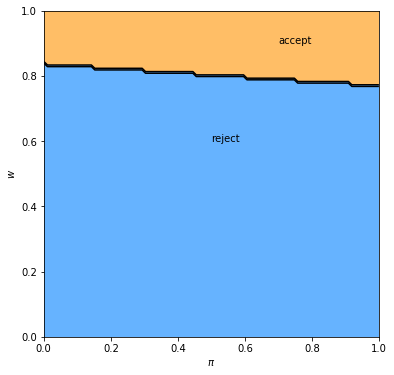

In [26]:
T, get_greedy = operator_factory(sp)
σ_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(sp.π_grid, sp.w_grid, σ_star, 1, alpha=0.6, cmap=cm.jet)
ax.contour(sp.π_grid, sp.w_grid, σ_star, 1, colors="black")
ax.set(xlabel='$\pi$', ylabel='$w$')

ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept')

plt.show()

In [27]:
def Q_factory(sp, parallel_flag=True):

    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid

    @njit
    def κ(w, π):
        """
        Updates π using Bayes' rule and the current wage observation w.
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)

        return π_new

    @njit(parallel=parallel_flag)
    def Q(ω):
        """
        Updates the reservation wage function guess ω via the operator Q.
        """
        ω_func = lambda p: interp(π_grid, ω, p)
        ω_new = np.empty_like(ω)

        for i in prange(len(π_grid)):
            π = π_grid[i]
            integral_f, integral_g = 0.0, 0.0

            for m in prange(mc_size):
                integral_f += max(w_f[m], ω_func(κ(w_f[m], π)))
                integral_g += max(w_g[m], ω_func(κ(w_g[m], π)))
            integral = (π * integral_f + (1 - π) * integral_g) / mc_size

            ω_new[i] = (1 - β) * c + β * integral

        return ω_new

    return Q

Ecercise 1

![Ex1](img/js3_1.png)

In [29]:
def solve_wbar(sp,
               use_parallel=True,
               tol=1e-4,
               max_iter=1000,
               verbose=True,
               print_skip=5):

    Q = Q_factory(sp, use_parallel)

    # Set up loop
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid)

    # Initialize w
    w = np.ones_like(sp.π_grid)

    while i < max_iter and error > tol:
        w_new = Q(w)
        error = np.max(np.abs(w - w_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        w = w_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return w_new

Error at iteration 5 is 0.021963789250806.
Error at iteration 10 is 0.007175085233258827.
Error at iteration 15 is 0.0018348079673928819.
Error at iteration 20 is 0.0004320786276512667.
Error at iteration 25 is 0.00010140071164177478.

Converged in 26 iterations.


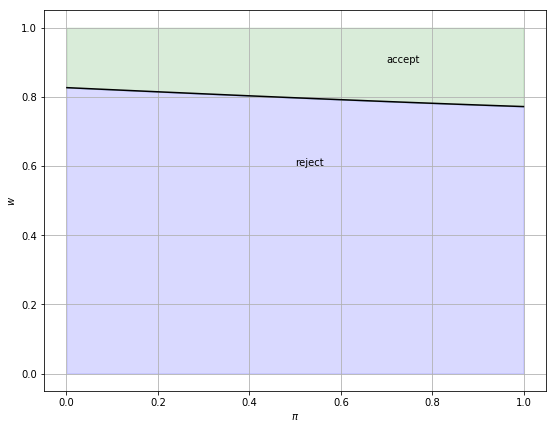

In [30]:
sp = SearchProblem()
w_bar = solve_wbar(sp)

fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(sp.π_grid, w_bar, color='k')
ax.fill_between(sp.π_grid, 0, w_bar, color='blue', alpha=0.15)
ax.fill_between(sp.π_grid, w_bar, sp.w_max, color='green', alpha=0.15)
ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept')
ax.set(xlabel='$\pi$', ylabel='$w$')
ax.grid()
plt.show()

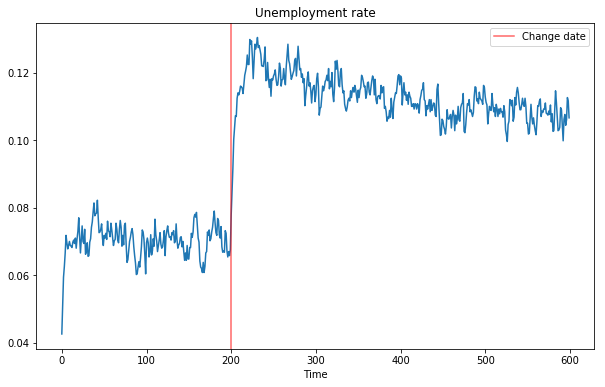

In [31]:
F_a, F_b, G_a, G_b = 1, 1, 3, 1.2

sp = SearchProblem(F_a=F_a, F_b=F_b, G_a=G_a, G_b=G_b)
f, g = sp.f, sp.g

# Solve for reservation wage
w_bar = solve_wbar(sp, verbose=False)

# Interpolate reservation wage function
π_grid = sp.π_grid
w_func = njit(lambda x: interp(π_grid, w_bar, x))

@njit
def update(a, b, e, π):
    """
    Update e and π by drawing wage offer from beta distribution with
    parameters a and b
    """

    if e == False:
        w = np.random.beta(a, b)       # Draw random wage
        if w >= w_func(π):
            e = True                   # Take new job
        else:
            π = 1 / (1 + ((1 - π) * g(w)) / (π * f(w)))

    return e, π

@njit
def simulate_path(F_a=F_a,
                  F_b=F_b,
                  G_a=G_a,
                  G_b=G_b,
                  N=5000,       # Number of agents
                  T=600,        # Simulation length
                  d=200,        # Change date
                  s=0.025):     # Separation rate

    """
    Simulates path of employment for N number of works over T periods
    """

    e = np.ones((N, T+1))
    π = np.ones((N, T+1)) * 1e-3

    a, b = G_a, G_b   # Initial distribution parameters

    for t in range(T+1):

        if t == d:
            a, b = F_a, F_b  # Change distribution parameters

        # Update each agent
        for n in range(N):
            # If agent is currently employed
            if e[n, t] == 1:
                p = np.random.uniform(0, 1)
                # Randomly separate with probability s
                if p <= s:
                    e[n, t] = 0

            new_e, new_π = update(a, b, e[n, t], π[n, t])
            e[n, t+1] = new_e
            π[n, t+1] = new_π

    return e[:, 1:]

d = 200  # Change distribution at time d
unemployment_rate = 1 - simulate_path(d=d).mean(axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(unemployment_rate)
ax.axvline(d, color='r', alpha=0.6, label='Change date')
ax.set_xlabel('Time')
ax.set_title('Unemployment rate')
ax.legend()
plt.show()

#### Lesson: Job Search IV: Modeling Career Choice

In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit, prange
from quantecon.distributions import BetaBinomial
from scipy.special import binom, beta
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

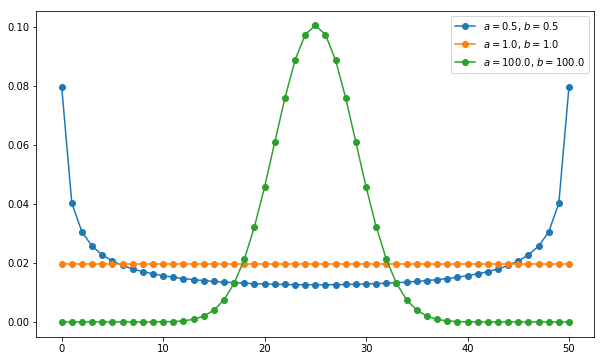

In [2]:
def gen_probs(n, a, b):
    probs = np.zeros(n+1)
    for k in range(n+1):
        probs[k] = binom(n, k) * beta(k + a, n - k + b) / beta(a, b)
    return probs

n = 50
a_vals = [0.5, 1, 100]
b_vals = [0.5, 1, 100]
fig, ax = plt.subplots(figsize=(10, 6))
for a, b in zip(a_vals, b_vals):
    ab_label = f'$a = {a:.1f}$, $b = {b:.1f}$'
    ax.plot(list(range(0, n+1)), gen_probs(n, a, b), '-o', label=ab_label)
ax.legend()
plt.show()

In [3]:
class CareerWorkerProblem:

    def __init__(self,
                 B=5.0,          # Upper bound
                 β=0.95,         # Discount factor
                 grid_size=50,   # Grid size
                 F_a=1,
                 F_b=1,
                 G_a=1,
                 G_b=1):

        self.β, self.grid_size, self.B = β, grid_size, B

        self.θ = np.linspace(0, B, grid_size)     # Set of θ values
        self.ϵ = np.linspace(0, B, grid_size)     # Set of ϵ values

        self.F_probs = BetaBinomial(grid_size - 1, F_a, F_b).pdf()
        self.G_probs = BetaBinomial(grid_size - 1, G_a, G_b).pdf()
        self.F_mean = np.sum(self.θ * self.F_probs)
        self.G_mean = np.sum(self.ϵ * self.G_probs)

        # Store these parameters for str and repr methods
        self._F_a, self._F_b = F_a, F_b
        self._G_a, self._G_b = G_a, G_b

In [4]:
def operator_factory(cw, parallel_flag=True):

    """
    Returns jitted versions of the Bellman operator and the
    greedy policy function

    cw is an instance of ``CareerWorkerProblem``
    """

    θ, ϵ, β = cw.θ, cw.ϵ, cw.β
    F_probs, G_probs = cw.F_probs, cw.G_probs
    F_mean, G_mean = cw.F_mean, cw.G_mean

    @njit(parallel=parallel_flag)
    def T(v):
        "The Bellman operator"

        v_new = np.empty_like(v)

        for i in prange(len(v)):
            for j in prange(len(v)):
                v1 = θ[i] + ϵ[j] + β * v[i, j]                    # Stay put
                v2 = θ[i] + G_mean + β * v[i, :] @ G_probs        # New job
                v3 = G_mean + F_mean + β * F_probs @ v @ G_probs  # New life
                v_new[i, j] = max(v1, v2, v3)

        return v_new

    @njit
    def get_greedy(v):
        "Computes the v-greedy policy"

        σ = np.empty(v.shape)

        for i in range(len(v)):
            for j in range(len(v)):
                v1 = θ[i] + ϵ[j] + β * v[i, j]
                v2 = θ[i] + G_mean + β * v[i, :] @ G_probs
                v3 = G_mean + F_mean + β * F_probs @ v @ G_probs
                if v1 > max(v2, v3):
                    action = 1
                elif v2 > max(v1, v3):
                    action = 2
                else:
                    action = 3
                σ[i, j] = action

        return σ

    return T, get_greedy

In [5]:
def solve_model(cw,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    T, _ = operator_factory(cw, parallel_flag=use_parallel)

    # Set up loop
    v = np.ones((cw.grid_size, cw.grid_size)) * 100  # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

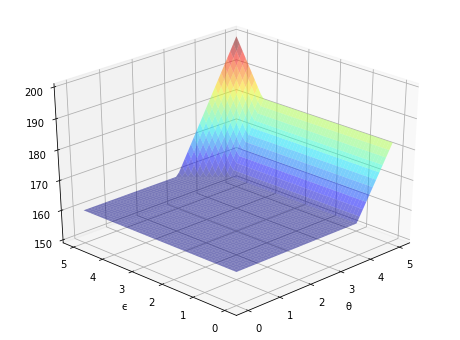

In [6]:
cw = CareerWorkerProblem()
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
ax.plot_surface(tg,
                eg,
                v_star.T,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set(xlabel='θ', ylabel='ϵ', zlim=(150, 200))
ax.view_init(ax.elev, 225)
plt.show()

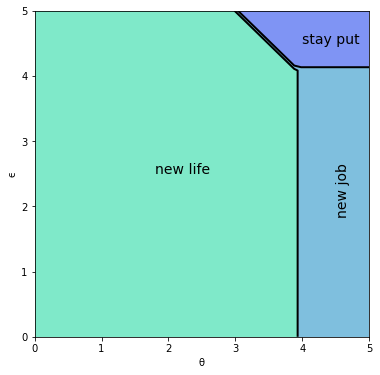

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
lvls = (0.5, 1.5, 2.5, 3.5)
ax.contourf(tg, eg, greedy_star.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, greedy_star.T, colors='k', levels=lvls, linewidths=2)
ax.set(xlabel='θ', ylabel='ϵ')
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.5, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.0, 4.5, 'stay put', fontsize=14)
plt.show()

Ecercise 1

![Ex1](img/js4_1.png)

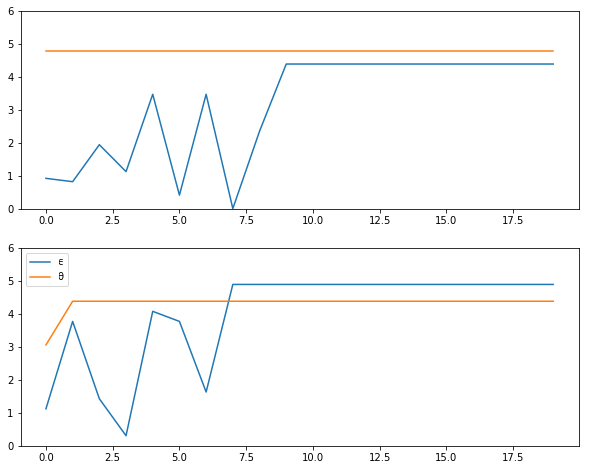

In [9]:
F = np.cumsum(cw.F_probs)
G = np.cumsum(cw.G_probs)
v_star = solve_model(cw, verbose=False)
T, get_greedy = operator_factory(cw)
greedy_star = get_greedy(v_star)

def gen_path(optimal_policy, F, G, t=20):
    i = j = 0
    θ_index = []
    ϵ_index = []
    for t in range(t):
        if greedy_star[i, j] == 1:       # Stay put
            pass
        elif greedy_star[i, j] == 2:     # New job
            j = int(qe.random.draw(G))
        else:                            # New life
            i, j = int(qe.random.draw(F)), int(qe.random.draw(G))
        θ_index.append(i)
        ϵ_index.append(j)
    return cw.θ[θ_index], cw.ϵ[ϵ_index]


fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for ax in axes:
    θ_path, ϵ_path = gen_path(greedy_star, F, G)
    ax.plot(ϵ_path, label='ϵ')
    ax.plot(θ_path, label='θ')
    ax.set_ylim(0, 6)

plt.legend()
plt.show()



Ecercise 2

![Ex2](img/js4_2.png)

In [11]:
cw = CareerWorkerProblem()
F = np.cumsum(cw.F_probs)
G = np.cumsum(cw.G_probs)
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

@njit
def passage_time(optimal_policy, F, G):
    t = 0
    i = j = 0
    while True:
        if optimal_policy[i, j] == 1:    # Stay put
            return t
        elif optimal_policy[i, j] == 2:  # New job
            j = int(qe.random.draw(G))
        else:                            # New life
            i, j  = int(qe.random.draw(F)), int(qe.random.draw(G))
        t += 1

@njit(parallel=True)
def median_time(optimal_policy, F, G, M=25000):
    samples = np.empty(M)
    for i in prange(M):
        samples[i] = passage_time(optimal_policy, F, G)
    return np.median(samples)

median_time(greedy_star, F, G)

7.0

Ecercise 3

![Ex1](img/js4_3.png)

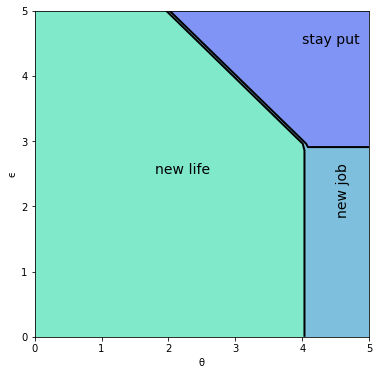

In [12]:
cw = CareerWorkerProblem(G_a=100, G_b=100)
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
lvls = (0.5, 1.5, 2.5, 3.5)
ax.contourf(tg, eg, greedy_star.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, greedy_star.T, colors='k', levels=lvls, linewidths=2)
ax.set(xlabel='θ', ylabel='ϵ')
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.5, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.0, 4.5, 'stay put', fontsize=14)
plt.show()

#### Lesson: Job Search V: On-the-Job Search

In [1]:
import numpy as np
import scipy.stats as stats
from interpolation import interp
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline
from math import gamma

In [2]:
class JVWorker:
    r"""
    A Jovanovic-type model of employment with on-the-job search.

    """

    def __init__(self,
                 A=1.4,
                 α=0.6,
                 β=0.96,         # Discount factor
                 π=np.sqrt,      # Search effort function
                 a=2,            # Parameter of f
                 b=2,            # Parameter of f
                 grid_size=50,
                 mc_size=100,
                 ɛ=1e-4):

        self.A, self.α, self.β, self.π = A, α, β, π
        self.mc_size, self.ɛ = mc_size, ɛ

        self.g = njit(lambda x, ϕ: A * (x * ϕ)**α)    # Transition function
        self.f_rvs = np.random.beta(a, b, mc_size)

        # Max of grid is the max of a large quantile value for f and the
        # fixed point y = g(y, 1)
        ɛ = 1e-4
        grid_max = max(A**(1 / (1 - α)), stats.beta(a, b).ppf(1 - ɛ))

        # Human capital
        self.x_grid = np.linspace(ɛ, grid_max, grid_size)

In [3]:
def operator_factory(jv, parallel_flag=True):

    """
    Returns a jitted version of the Bellman operator T

    jv is an instance of JVWorker

    """

    π, β = jv.π, jv.β
    x_grid, ɛ, mc_size = jv.x_grid, jv.ɛ, jv.mc_size
    f_rvs, g = jv.f_rvs, jv.g

    @njit
    def objective(z, x, v):
        s, ϕ = z
        v_func = lambda x: interp(x_grid, v, x)

        integral = 0
        for m in range(mc_size):
            u = f_rvs[m]
            integral += v_func(max(g(x, ϕ), u))
        integral = integral / mc_size

        q = π(s) * integral + (1 - π(s)) * v_func(g(x, ϕ))
        return x * (1 - ϕ - s) + β * q

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator
        """

        v_new = np.empty_like(v)
        for i in prange(len(x_grid)):
            x = x_grid[i]

            # Search on a grid
            search_grid = np.linspace(ɛ, 1, 15)
            max_val = -1
            for s in search_grid:
                for ϕ in search_grid:
                    current_val = objective((s, ϕ), x, v) if s + ϕ <= 1 else -1
                    if current_val > max_val:
                        max_val = current_val
            v_new[i] = max_val

        return v_new

    @njit
    def get_greedy(v):
        """
        Computes the v-greedy policy of a given function v
        """
        s_policy, ϕ_policy = np.empty_like(v), np.empty_like(v)

        for i in range(len(x_grid)):
            x = x_grid[i]
            # Search on a grid
            search_grid = np.linspace(ɛ, 1, 15)
            max_val = -1
            for s in search_grid:
                for ϕ in search_grid:
                    current_val = objective((s, ϕ), x, v) if s + ϕ <= 1 else -1
                    if current_val > max_val:
                        max_val = current_val
                        max_s, max_ϕ = s, ϕ
                        s_policy[i], ϕ_policy[i] = max_s, max_ϕ
        return s_policy, ϕ_policy

    return T, get_greedy

In [4]:
def solve_model(jv,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    """
    Solves the model by value function iteration

    * jv is an instance of JVWorker

    """

    T, _ = operator_factory(jv, parallel_flag=use_parallel)

    # Set up loop
    v = jv.x_grid * 0.5  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

In [5]:
jv = JVWorker()
T, get_greedy = operator_factory(jv)
v_star = solve_model(jv)
s_star, ϕ_star = get_greedy(v_star)

Error at iteration 25 is 0.15111466302400522.
Error at iteration 50 is 0.05446122839706646.
Error at iteration 75 is 0.019627647910361645.
Error at iteration 100 is 0.007073739866541473.
Error at iteration 125 is 0.002549352623811174.
Error at iteration 150 is 0.0009187783157393881.
Error at iteration 175 is 0.00033112468851470567.
Error at iteration 200 is 0.00011933625061111286.

Converged in 205 iterations.


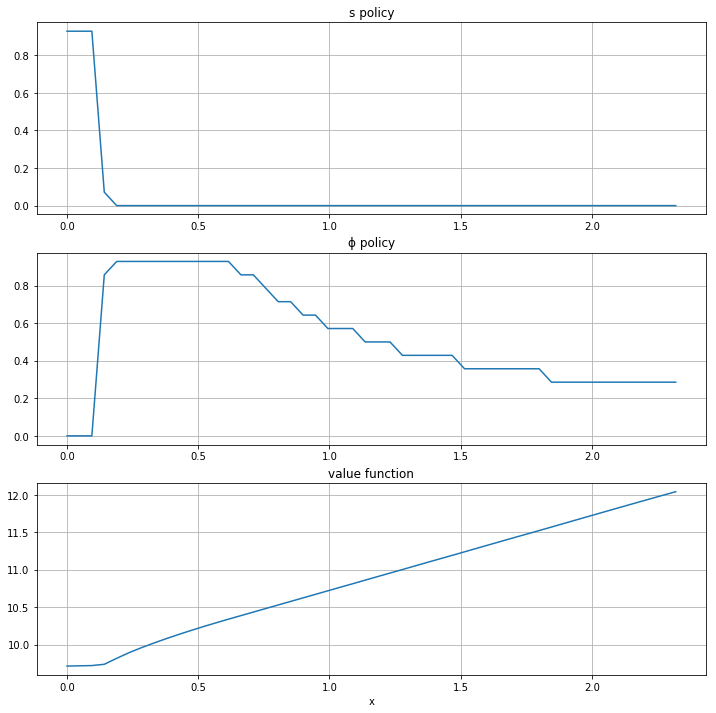

In [6]:
plots = [s_star, ϕ_star, v_star]
titles = ["s policy", "ϕ policy",  "value function"]

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

for ax, plot, title in zip(axes, plots, titles):
    ax.plot(jv.x_grid, plot)
    ax.set(title=title)
    ax.grid()

axes[-1].set_xlabel("x")
plt.show()



Ecercise 1

![Ex1](img/js5_1.png)

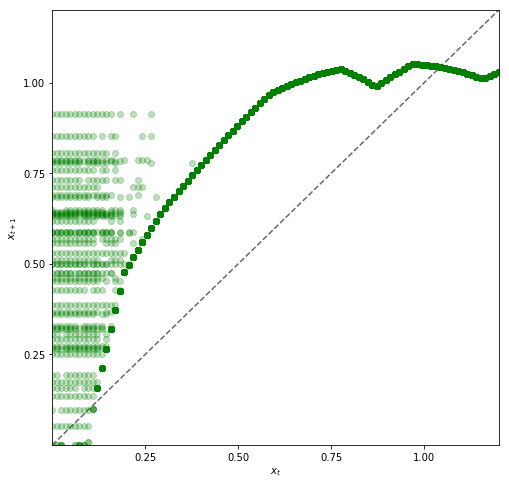

In [7]:
jv = JVWorker(grid_size=25, mc_size=50)
π, g, f_rvs, x_grid = jv.π, jv.g, jv.f_rvs, jv.x_grid
T, get_greedy = operator_factory(jv)
v_star = solve_model(jv, verbose=False)
s_policy, ϕ_policy = get_greedy(v_star)

# Turn the policy function arrays into actual functions
s = lambda y: interp(x_grid, s_policy, y)
ϕ = lambda y: interp(x_grid, ϕ_policy, y)

def h(x, b, u):
    return (1 - b) * g(x, ϕ(x)) + b * max(g(x, ϕ(x)), u)


plot_grid_max, plot_grid_size = 1.2, 100
plot_grid = np.linspace(0, plot_grid_max, plot_grid_size)
fig, ax = plt.subplots(figsize=(8, 8))
ticks = (0.25, 0.5, 0.75, 1.0)
ax.set(xticks=ticks, yticks=ticks,
       xlim=(0, plot_grid_max),
       ylim=(0, plot_grid_max),
       xlabel='$x_t$', ylabel='$x_{t+1}$')

ax.plot(plot_grid, plot_grid, 'k--', alpha=0.6)  # 45 degree line
for x in plot_grid:
    for i in range(jv.mc_size):
        b = 1 if np.random.uniform(0, 1) < π(s(x)) else 0
        u = f_rvs[i]
        y = h(x, b, u)
        ax.plot(x, y, 'go', alpha=0.25)

plt.show()

Ecercise 2

![Ex1](img/js5_2.png)

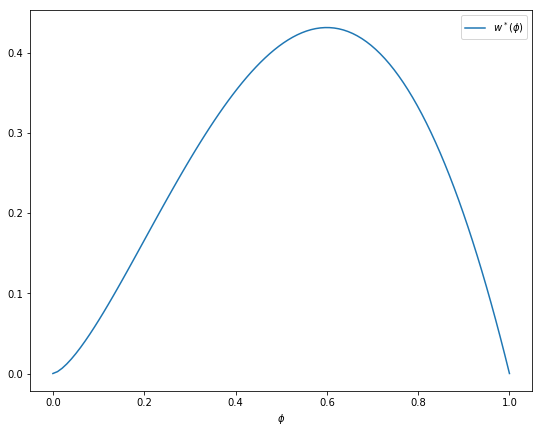

In [8]:
jv = JVWorker()

def xbar(ϕ):
    A, α = jv.A, jv.α
    return (A * ϕ**α)**(1 / (1 - α))

ϕ_grid = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(9, 7))
ax.set(xlabel='$\phi$')
ax.plot(ϕ_grid, [xbar(ϕ) * (1 - ϕ) for ϕ in ϕ_grid], label='$w^*(\phi)$')
ax.legend()

plt.show()